In [1]:
import requests
import pandas as pd
import numpy as np

In [2]:
api_map = '314b5dfe-b743-47ad-bb43-92229cca7080'

In [3]:
def cordinate(lat, lon):
    
    # отрпавляю запрос в геокодер, чтобы получить адрес по координатам
    url = "https://geocode-maps.yandex.ru/1.x/"
    config = {
        'apikey' : api_map,
        'geocode' : f"{lon}, {lat}",
        'format' : 'json'
        
    }
    
    response = requests.get(url, params=config)
    response.raise_for_status()
    data = response.json()
    
    # получаю адреса
    
    address = (
        data.get("response", {})
        .get("GeoObjectCollection", {})
        .get("featureMember", [{}])[0]
        .get("GeoObject", {})
        .get("metaDataProperty", {})
        .get("GeocoderMetaData", {})
        .get("text", "Адрес не найден")
    )
    
    return address

In [7]:
def coordinate_from_df(df_coordinate):
    df_coordinate = pd.read_csv(df_coordinate)
    
    # удалил строки с пропущенными значениями
    df_coordinate = df_coordinate.dropna()

    addr_list = []
    for i, j in df_coordinate.iterrows():    

        # преобразовал тип данных в float
        try:
            j['lat'] = float(j['lat'])
            j['lon'] = float(j['lon'])
        except (ValueError, TypeError):
            j['lat'] = j['lat']
            j['lon'] = j['lon']

        # добавил только числовые значения координат
        if isinstance(j['lat'], float) and isinstance(j['lon'], float):
            address = cordinate(j['lat'], j['lon'])
            addr_list.append(address)
        else:
            addr_list.append(False)
            
    
    df_coordinate['address'] = addr_list
    df_coordinate.to_csv('part1_moscow_coordinate_add_address.csv', index=False)
    
    # записал в отдельный файл и возвращаю датафрейм
    df = pd.read_csv('part1_moscow_coordinate_add_address.csv')
    return df

Попробовал поработать с неправильными значениями. Если вставлять в координаты слова и символы, то не происходит никакой ошибки. Мы всё равно получаем адрес. Но я всё же сделал в функции выше проверку на правильность входных символов
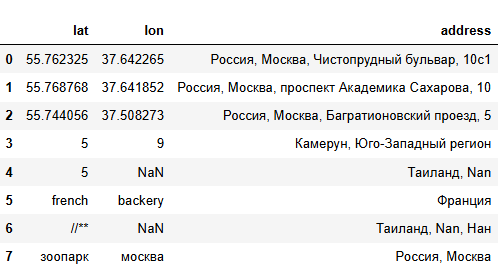

In [8]:
df_coordinate = 'part1_city_coordinate.csv'

In [9]:
coordinate_from_df(df_coordinate)

,lat,lon,address
0,55.762325,37.642265,"Россия, Москва, Чистопрудный бульвар, 10с1"
1,55.768768,37.641852,"Россия, Москва, проспект Академика Сахарова, 10"
2,55.744056,37.508273,"Россия, Москва, Багратионовский проезд, 5"
3,5.0,9.0,"Камерун, Юго-Западный регион"
4,french,backery,False
5,зоопарк,москва,False


На выходе имеем файл 'moscow_coordinate_add_address.csv'

### Часть два

In [10]:
# функция для получения адреса, района, округа и метро

def get_districts(lat, lon):
    # отрпавляю запрос в геокодер, чтобы получить адрес по координатам
    url = "https://geocode-maps.yandex.ru/1.x/"
    config = {
        'apikey' : api_map,
        'geocode' : f"{lon}, {lat}",
        'format' : 'json',
        'kind' : 'district'
        
    }
    
    response = requests.get(url, params=config)
    response.raise_for_status()
    data = response.json()
    
    # получаю данных
    
    address = (
        data.get("response", {})
        .get("GeoObjectCollection", {})
        .get("featureMember", [{}])[0]
        .get("GeoObject", {})
    )
    
    # создаю списки, и потом вставляю данные на первую позицию. Если данных нет, то возвращается "Нет данных"
    addr = ['Нет данных']
    district = ['Нет данных']
    big_district = ['Нет данных']
        
    # тут я итерирую по json данным
    for i in address:
        if i == 'description':
            for j in address[i].split(','):
                if 'район' in j.lower():
                    district.insert(0, j)
                elif 'округ' in j.lower():
                    big_district.insert(0, j)
        elif i == 'metaDataProperty':
            addr.insert(0, address[i]['GeocoderMetaData']['text'])
            
    return addr[0], district[0], big_district[0]

In [14]:
# функция для получения адреса, района, округа и метро

def get_districts(lat, lon):
    # отрпавляю запрос в геокодер, чтобы получить адрес по координатам
    url = "https://geocode-maps.yandex.ru/1.x/"
    config = {
        'apikey' : api_map,
        'geocode' : f"{lon}, {lat}",
        'format' : 'json',
        'kind' : 'district'
        
    }
    
    response = requests.get(url, params=config)
    response.raise_for_status()
    data = response.json()
    
    # получаю данных
    
    address = (
        data.get("response", {})
        .get("GeoObjectCollection", {})
        .get("featureMember", [{}])[0]
        .get("GeoObject", {})
    )
    
    # создаю списки, и потом вставляю данные на первую позицию. Если данных нет, то возвращается "Нет данных"
    # пытался использовать массив numpy для ускорения выполнения, но заметного прироста не было, поэтому в следующих функция использовал списки
    addr = np.array(['Нет данных'])
    district = np.array(['Нет данных'])
    big_district = np.array(['Нет данных'])
        
    # тут я итерирую по json данным
    for i in address:
        if i == 'description':
            for j in address[i].split(','):
                if 'район' in j.lower():
                    np.insert(district, 0, j)
                elif 'округ' in j.lower():
                    np.insert(big_district, 0, j)
        elif i == 'metaDataProperty':
            np.insert(addr, 0, address[i]['GeocoderMetaData']['text'])
            
    return addr[0], district[0], big_district[0]

In [12]:
# функция для получения метро. Так как kind может хранить один параметр. 
# Либо метро, либо район

def get_metro(lat, lon):
    # отрпавляю запрос в геокодер, чтобы получить адрес по координатам
    url = "https://geocode-maps.yandex.ru/1.x/"
    config = {
        'apikey' : api_map,
        'geocode' : f"{lon}, {lat}",
        'format' : 'json',
        'kind' : 'metro'
        
    }
    
    response = requests.get(url, params=config)
    response.raise_for_status()
    data = response.json()
    
    metro = ['Нет данных']
    
    # получаю адреса
    try:
        address = (
            data.get("response", {})
            .get("GeoObjectCollection", {})
            .get("featureMember", [{}])[0]
            .get("GeoObject", {})
        )
    except IndexError:
        return metro[0]
    
    
    for i in address:
        if i == 'name':
            for j in address[i].split(','):
                if 'метро' in j.lower():
                    metro.insert(0, j)
    return metro[0]

In [15]:
def coordinate_from_df(df_coordinate):
    df_coordinate = pd.read_csv(df_coordinate)
    
    # удалил строки с пропущенными значениями
    df_coordinate = df_coordinate.dropna()

    addr_list = []
    distr_list = []
    big_distr_list = []
    metro_list = []
    for i, j in df_coordinate.iterrows():    

        # преобразовал тип данных в float
        try:
            j['lat'] = float(j['lat'])
            j['lon'] = float(j['lon'])
        except (ValueError, TypeError):
            j['lat'] = j['lat']
            j['lon'] = j['lon']

        # добавил только числовые значения координат
        if isinstance(j['lat'], float) and isinstance(j['lon'], float):
            address = get_districts(j['lat'], j['lon'])
            addr_list.append(address[0])
            
            distr = get_districts(j['lat'], j['lon'])
            distr_list.append(distr[1])
            big_distr_list.append(distr[2])

            metro = get_metro(j['lat'], j['lon'])
            metro_list.append(metro)
        else:
            addr_list.append(False)
            
    df_coordinate['address'] = addr_list
    df_coordinate['district'] = distr_list
    df_coordinate['big_district'] = big_distr_list
    df_coordinate['metro'] = metro_list
    df_coordinate.to_csv('part2_full_address.csv', index=False)
    
    # записал в отдельный файл и возвращаю датафрейм
    df = pd.read_csv('part2_full_address.csv')
    return df

In [16]:
df_coordinate = 'part2_city_coordinate.csv'

In [17]:
coordinate_from_df(df_coordinate)

,lat,lon,address,district,big_district,metro
0,55.762325,37.642265,Нет данных,Нет данных,Нет данных,метро Чистые пруды
1,59.942721,30.327626,Нет данных,Нет данных,Нет данных,метро Невский проспект
2,55.682295,37.702227,Нет данных,Нет данных,Нет данных,метро Нагатинский Затон


In [18]:
# # можно замерить время выполнения кода, для дальнейшей оптимизации

# import pandas as pd
# import time

# start_time = time.time()
# coordinate_from_df(df_coordinate)
# end_time = time.time()
# execution_time = end_time - start_time
# print("Время выполнения: ", execution_time)